<a   href="https://colab.research.google.com/github/N-Nieto/OHBM_SEA-SIG_Educational_Course/blob/master/03_pitfalls/03_03_imbalance_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imbalance learning: Metrics

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    balanced_accuracy_score,
    ConfusionMatrixDisplay,
)

from imblearn.metrics import sensitivity_specificity_support

import warnings

warnings.filterwarnings("ignore", category=FutureWarning)  # Ignore


### Data loading and preparation

In [2]:
# Prepare the data
# Features: Cortical + Subcortical
features = ["cortical", "subcortical"]

# Target: Height
target = ["SEX_ID (1=m, 2=f)"]
# Confounding variables: Sex, Age
confounding = ["SEX_ID (1=m, 2=f)", "AGE"]
confounding = []


df_data = pd.read_csv("cleaned_IXI_behavioural.csv", index_col=0)
columns_features = []
for feature in features:
    if feature == "cortical":
        df_feature = pd.read_csv(
            "cleaned_VBM_GM_Schaefer100x17_mean_aggregation.csv", index_col=0
        )
    elif feature == "subcortical":
        df_feature = pd.read_csv(
            "cleaned_VBM_GM_TianxS1x3TxMNI6thgeneration_mean_aggregation.csv",
            index_col=0,
        )
    else:
        print("feature not recognized")

    df_data = df_data.join(df_feature, how="inner")
    columns_features = columns_features + df_feature.columns.to_list()


print(f"Initial data shape: {df_data.shape}")

# Check for NaNs in confounding columns
confounding_cols = target + confounding
for col in confounding_cols:
    if df_data[col].isna().sum() > 0:
        print(f"{df_data[col].isna().sum()} NaNs in column {col}.")
        print("Drop NaNs and align subjects")

        # Drop NaNs from the brain dataframe (which contains all columns)
        df_data = df_data.dropna(subset=[col])
        print(f"New data shape: {df_data.shape}")
    else:
        print(f"No NaNs in column {col}.")

print(f"Final data shape: {df_data.shape}")

y = df_data[target].values.ravel()
if target == ["SEX_ID (1=m, 2=f)"]:
    y = np.where(y == 2, 0, 1)  # 1


X = df_data.loc[:, columns_features].values  # only brain features

print("X shape")
print(X.shape)


Initial data shape: (591, 122)
No NaNs in column SEX_ID (1=m, 2=f).
Final data shape: (591, 122)
X shape
(591, 116)


### Forcing Imbalance

In [3]:
# Force imbalance in the dataset
imbalance_ratio = 0.15  # Minority class will be 10% of majority class
X_minority = X[y == 0]
y_minority = y[y == 0]
X_majority = X[y == 1][: int(imbalance_ratio * len(X_minority))]
y_majority = y[y == 1][
    : int(imbalance_ratio * len(X_minority))
]  # Keep only 10% of majority class
X = np.vstack((X_minority, X_majority))
y = np.hstack((y_minority, y_majority))

print("X shape")
print(X.shape)
print("Target distribution")
print(y.sum(), len(y) - y.sum())
print(f"Imbalance ratio: {y.sum()/len(y):.2f}")

X shape
(377, 116)
Target distribution
49 328
Imbalance ratio: 0.13


## Training a ML model and plot performance

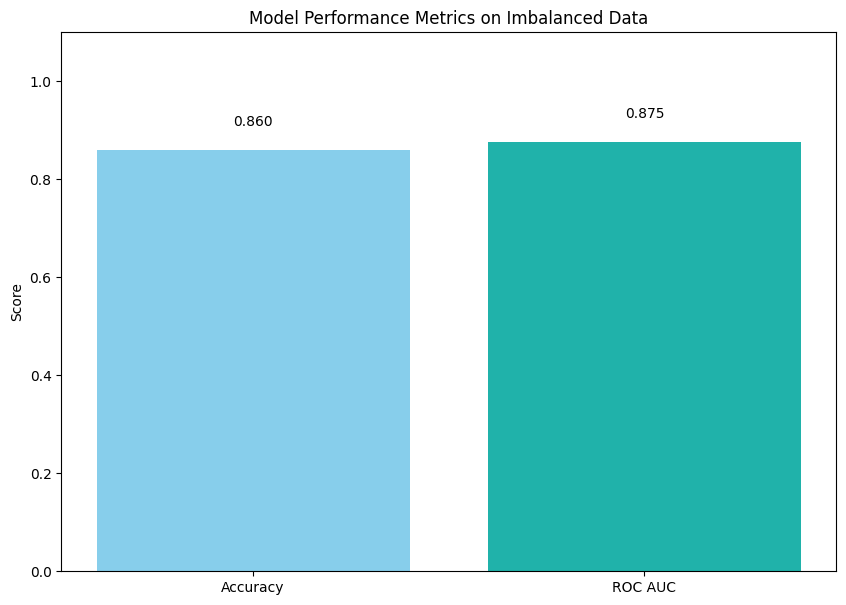

In [15]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Train logistic regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]


# Calculate metrics
metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "ROC AUC": roc_auc_score(y_test, y_proba),
}


# Plot metrics
plt.figure(figsize=(10, 7))
plt.bar(
    metrics.keys(),
    metrics.values(),
    color=[
        "skyblue",
        "lightseagreen",
    ],
)
plt.title("Model Performance Metrics on Imbalanced Data")
plt.ylim(0, 1.1)
plt.ylabel("Score")
for i, v in enumerate(metrics.values()):
    plt.text(i, v + 0.05, f"{v:.3f}", ha="center")
plt.show()


## Looks great, doesn't it?!

### Let's now take a look at our confusion matrix

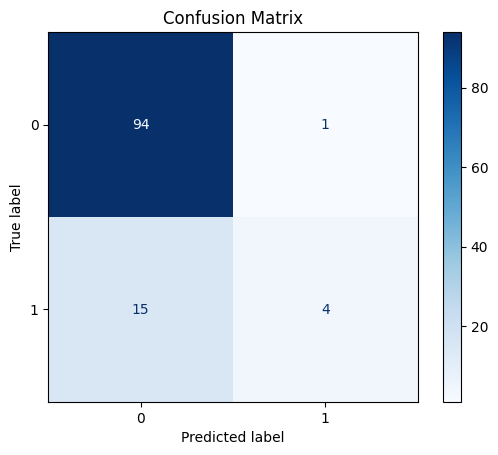

In [5]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


# Wait, we clearly have a problem, our classifier is not working well in our minority class!

## We need to characterize better our results. Let's calculate more metrics!

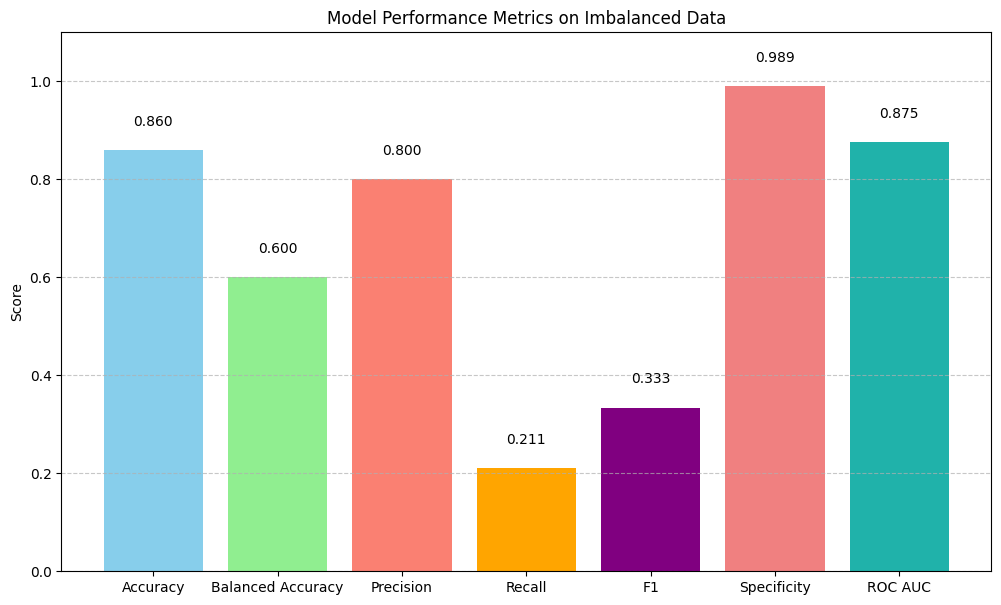

In [16]:
# Calculate metrics
metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Balanced Accuracy": balanced_accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1": f1_score(y_test, y_pred),
    "Specificity": sensitivity_specificity_support(y_test, y_pred)[0][0],
    "ROC AUC": roc_auc_score(y_test, y_proba),
}


# Plot metrics
plt.figure(figsize=(12, 7))
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.bar(
    metrics.keys(),
    metrics.values(),
    color=[
        "skyblue",
        "lightgreen",
        "salmon",
        "orange",
        "purple",
        "lightcoral",
        "lightseagreen",
    ],
)
plt.title("Model Performance Metrics on Imbalanced Data")
plt.ylim(0, 1.1)

plt.ylabel("Score")
for i, v in enumerate(metrics.values()):
    plt.text(i, v + 0.05, f"{v:.3f}", ha="center")
plt.show()


# Question

What is your take from the metrics?

We should always report several metrics, to better understand the models' performance.

# ----------------------------------------------------------------

# Threshold ajustment

## By default, sklearn prediction use a threshold of 0.5, but we could aproximate a better threshold

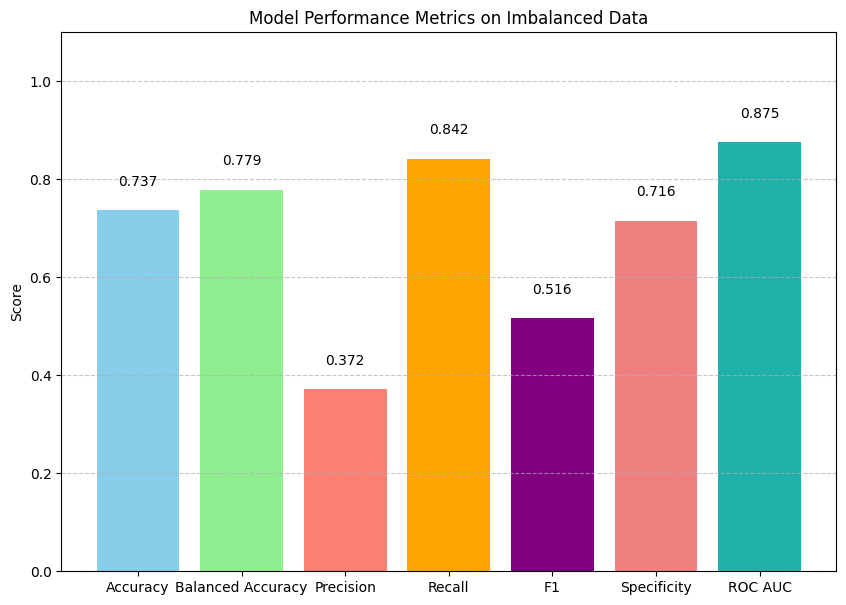

In [17]:
# get the probabilities again
y_proba = model.predict_proba(X_test)[:, 1]

# Adjust threshold based on class imbalance
# this is an approximation of the optimal threshold in terms of balanced accuracy
thd = y.sum()/len(y)

# Get new predictions using the adjusted threshold
y_pred = y_proba >= thd
# Calculate metrics
metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Balanced Accuracy": balanced_accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1": f1_score(y_test, y_pred),
    "Specificity": sensitivity_specificity_support(y_test, y_pred)[0][0],
    "ROC AUC": roc_auc_score(y_test, y_proba),
}


# Plot metrics
plt.figure(figsize=(10, 7))
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.bar(
    metrics.keys(),
    metrics.values(),
    color=[
        "skyblue",
        "lightgreen",
        "salmon",
        "orange",
        "purple",
        "lightcoral",
        "lightseagreen",
    ],
)
plt.title("Model Performance Metrics on Imbalanced Data")
plt.ylim(0, 1.1)

plt.ylabel("Score")
for i, v in enumerate(metrics.values()):
    plt.text(i, v + 0.05, f"{v:.3f}", ha="center")
plt.show()

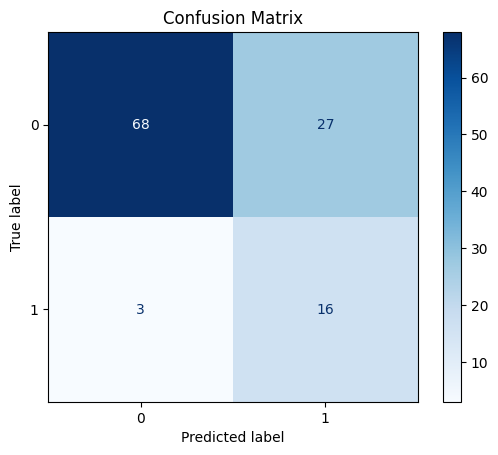

In [18]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


# Questions

What can you observe? How is the relationship between ACC and Balanced ACC now?

Did AUC change? Why, why not?

We improved our performance on the minority class, but at what cost?

The decision of which type of error is more critical is problem dependant, you as the expert, will have to take this decision.

So far, we did not change the model itself, only treated differently the predictions that the model made.
In the next notebook, we will explore particular techniques to deal with imbalance problems.